<img src='logo.png' align='center'>
<div align='center' class="h2">深度学习理论与实践编程练习(Course 03)</div>

-----
### 命名格式：按照课程网站中的课后作业要求
-----

#### 1. 根据Course03课程中对卷积神经网络的讲解，将缺失的全连接神经网络中代码块补全，并完成一次训练
    [1] img2col 函数补全，通过补全函数，了解其实际含义
    [2] Conv类中的前向过程
    [3] Conv类中后向过程的 权重更新与误差反向传播
    [4] Pool函数中的最大位置mask的计算过程
    
    
#### 2. 修改卷积和池化的总操作数，观察对结果的影响
    [1] 卷积后面跟随卷积层然后再接池化层，或者是用多个卷积池化操作的串联，观察对结果的影响。
    [2] 修改的时候可以增加conv3和pool3实例，也可以修改卷积核的大小和卷积核的个数。
-----

<img src='CNN.png' align='center'>

In [1]:
## 引入python包，没有安装的请按照抛出的error通过conda来安装直至成功
import numpy as np
import torchvision

np.set_printoptions(threshold=np.inf)

In [52]:
def onehot(targets, num):
    """将数字的label转换成One-Hot的形式"""
    result = np.zeros((num, 10))
    for i in range(num):
        result[i][targets[i]] = 1
    return result


def img2col(x, ksize, step):
    """
    将图像中所有需要卷积的地方转化成矩阵，方便卷积加速
    :param x: 图像
    :param ksize: 卷积大小
    :param step: 步长
    :return: 二维矩阵，每一行是所有深度上待卷积部分的一维形式
    """
    # [width,height,channel] 宽，长，深度
    wx, hx, cx = x.shape
    # 返回的特征图尺寸
    feature_w = (wx - ksize) // step + 1
    # 图片矩阵的行就是图片能被卷积核匹配多少次的平方， 列就是卷积核reshap(-1)的平方再乘上深度
    image_col = np.zeros((feature_w * feature_w, ksize * ksize * cx))
    num = 0
    ## 补全代码，补充image_col具体数值 ##
    for i in range(feature_w):
        for j in range(feature_w):
            image_col[num] = x[i * step: i * step + ksize, j * step : j * step + ksize, :].reshape(-1)
            num += 1
    return image_col

In [53]:
## Relu 函数
class Relu(object):
    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)

    def backward(self, delta):
        delta[self.x < 0] = 0
        return delta


## Softmax 函数
class Softmax(object):
    def cal_loss(self, predict, label):
        batchsize, classes = predict.shape
        self.predict(predict)
        loss = 0
        delta = np.zeros(predict.shape)
        for i in range(batchsize):
            delta[i] = self.softmax[i] - label[i]
            loss -= np.sum(np.log(self.softmax[i]) * label[i])
        loss /= batchsize
        return loss, delta

    def predict(self, predict):
        batchsize, classes = predict.shape
        self.softmax = np.zeros(predict.shape)
        for i in range(batchsize):
            predict_tmp = predict[i] - np.max(predict[i])
            predict_tmp = np.exp(predict_tmp)
            self.softmax[i] = predict_tmp / np.sum(predict_tmp)
        return self.softmax

In [54]:
dataset_path = "./datasets/mnist"
train_data = torchvision.datasets.MNIST(root=dataset_path, train=True, download=False)
train_data.data = train_data.data.numpy()  # [60000,28,28]
train_data.targets = train_data.targets.numpy()  # [60000]
train_data.data = train_data.data.reshape(60000, 28, 28, 1) / 255.  # 输入向量处理
train_data.targets = onehot(train_data.targets, 60000)  # 标签one-hot处理 (60000, 10)

In [55]:
## 全连接层
class Linear(object):

    def __init__(self, inChannel, outChannel):
        scale = np.sqrt(inChannel / 2)
        self.W = np.random.standard_normal((inChannel, outChannel)) / scale
        self.b = np.random.standard_normal(outChannel) / scale
        self.W_gradient = np.zeros((inChannel, outChannel))
        self.b_gradient = np.zeros(outChannel)

    def forward(self, x):
        """前向过程"""
        ## 补全代码 ##
        self.x = x 
        return np.dot(x, self.W) + self.b

    def backward(self, delta, learning_rate):
        """反向过程"""
        ## 梯度计算
        batch_size = self.x.shape[0]
        
        ## 补全代码 ##
        self.W_gradient = np.dot(self.x.T, delta) / batch_size
        self.b_gradient = np.sum(delta, axis=0) / batch_size
        delta_backward = np.dot(delta, self.W.T)
        ## 反向传播
        self.W -= learning_rate * self.W_gradient
        self.b -= learning_rate * self.b_gradient

        return delta_backward


In [56]:
## conv
class Conv(object):
    def __init__(self, kernel_shape, step=1, pad=0):
        # [w, h, d]
        width, height, in_channel, out_channel = kernel_shape
        self.step = step
        self.pad = pad
        scale = np.sqrt(3 * in_channel * width * height / out_channel)
        self.k = np.random.standard_normal(kernel_shape) / scale
        self.b = np.random.standard_normal(out_channel) / scale
        self.k_gradient = np.zeros(kernel_shape)
        self.b_gradient = np.zeros(out_channel)

    def forward(self, x):
        self.x = x
        if self.pad != 0:
            self.x = np.pad(self.x, ((0, 0), (self.pad, self.pad), (self.pad, self.pad), (0, 0)), 'constant')
        bx, wx, hx, cx = self.x.shape
        # kernel的宽、高、通道数、个数
        wk, hk, ck, nk = self.k.shape
        feature_w = (wx - wk) // self.step + 1  # 返回的特征图尺寸
        feature = np.zeros((bx, feature_w, feature_w, nk))

        self.image_col = []
        # kernal也进行了reshape，便于卷积加速，只保留通道维度，是个二维的矩阵
        kernel = self.k.reshape(-1, nk)
        
        ## 补全代码 ##
        for i in range(bx):
            image_col = img2col(self.x[i], wk, self.step)
            feature[i] = (np.dot(image_col, kernel) + self.b).reshape(feature_w, feature_w, nk)
            self.image_col.append(image_col)
        return feature

    def backward(self, delta, learning_rate):
        bx, wx, hx, cx = self.x.shape  # batch,14,14,inchannel
        wk, hk, ck, nk = self.k.shape  # 5,5,inChannel,outChannel
        bd, wd, hd, cd = delta.shape   # batch,10,10,outChannel

        # 计算self.k_gradient,self.b_gradient
        # 参数更新过程
        ## 补全代码 ##
        delta_col = delta.reshape(bd, -1, cd)
        for i in range(bx):
            self.k_gradient += np.dot(self.image_col[i].T, delta_col[i]).reshape(self.k.shape)
        self.k_gradient /= bx
        self.b_gradient += np.sum(delta_col, axis=(0, 1))
        self.b_gradient /= bx

        # 计算delta_backward
        # 误差的反向传递
        delta_backward = np.zeros(self.x.shape)
        # numpy矩阵（对应kernal）旋转180度
        ## 补全代码 ##
        k_180 = np.rot90(self.k, 2, (0, 1))
        k_180 = k_180.swapaxes(2, 3)
        k_180_col = k_180.reshape(-1, ck)

        if hd - hk + 1 != hx:
            pad = (hx - hd + hk - 1) // 2
            pad_delta = np.pad(delta, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant')
        else:
            pad_delta = delta

        for i in range(bx):
            pad_delta_col = img2col(pad_delta[i], wk, self.step)
            delta_backward[i] = np.dot(pad_delta_col, k_180_col).reshape(wx, hx, ck)

        # 反向传播
        self.k -= self.k_gradient * learning_rate
        self.b -= self.b_gradient * learning_rate

        return delta_backward

In [57]:
## Max Pooling层
class Pool(object):
    def forward(self, x):
        b, w, h, c = x.shape
        feature_w = w // 2
        feature = np.zeros((b, feature_w, feature_w, c))
        self.feature_mask = np.zeros((b, w, h, c))  # 记录最大池化时最大值的位置信息用于反向传播
        for bi in range(b):
            for ci in range(c):
                for i in range(feature_w):
                    for j in range(feature_w):
                        ## 补全代码
                        feature[bi, i, j, ci] = np.max(x[bi, i*2:i*2+2, j*2:j*2+2, ci])
                        index = np.argmax(x[bi, i * 2:i * 2 + 2, j * 2:j * 2 + 2, ci])
                        self.feature_mask[bi, i * 2 + index // 2, j * 2 + index % 2, ci] = 1
        return feature

    def backward(self, delta):
        return np.repeat(np.repeat(delta, 2, axis=1), 2, axis=2) * self.feature_mask


In [58]:
import matplotlib.pyplot as plt
train_loss_list = []
x = []

In [59]:
def show(x, y):
    fig = plt.figure(figsize = (7,5))
    plt.plot(x,y,'g-')
    plt.xlabel(u'iters')
    plt.ylabel(u'loss')
    plt.title('Compare loss for different models in training')
    plt.show()

In [60]:

def train(batch=32, lr=0.01, epochs=10):
    # Mnist手写数字集
    dataset_path = "./datasets/mnist"
    train_data = torchvision.datasets.MNIST(root=dataset_path, train=True, download=False)
    train_data.data = train_data.data.numpy()  # [60000,28,28]
    train_data.targets = train_data.targets.numpy()  # [60000]
    train_data.data = train_data.data.reshape(60000, 28, 28, 1) / 255.  # 输入向量处理
    train_data.targets = onehot(train_data.targets, 60000)  # 标签one-hot处理 (60000, 10)
    
    # [28,28] 卷积 6x[5,5] -> 6x[24,24]
    conv1 = Conv(kernel_shape=(5, 5, 1, 6))
    relu1 = Relu()
    # 6x[24,24] -> 6x[12,12]
    pool1 = Pool() 
    # 6x[12,12] 卷积 16x(6x[12,12]) -> 16x[8,8]
    conv2 = Conv(kernel_shape=(5, 5, 6, 16))  # 8x8x16
    relu2 = Relu()
    # 16x[8,8] -> 16x[4,4]
    pool2 = Pool() 
    
    # 在这里可以尝试增加网络的深度，再实例化conv3和pool3，记得后面的前向传播过程
    # 和反向传播过程也要有对应的过程
    
    nn = Linear(256, 10)
    softmax = Softmax()

    for epoch in range(epochs):
        for i in range(0, 60000, batch):
            X = train_data.data[i:i + batch]
            Y = train_data.targets[i:i + batch]
            # print(X.shape)
            # 前向传播过程
            predict = conv1.forward(X)
            predict = relu1.forward(predict)
            predict = pool1.forward(predict)
            predict = conv2.forward(predict)
            predict = relu2.forward(predict)
            predict = pool2.forward(predict)
            predict = predict.reshape(batch, -1)
            predict = nn.forward(predict)

            # 误差计算
            loss, delta = softmax.cal_loss(predict, Y)
            
            # 反向传播过程
            delta = nn.backward(delta, lr)
            delta = delta.reshape(batch, 4, 4, 16)
            delta = pool2.backward(delta)
            delta = relu2.backward(delta)
            delta = conv2.backward(delta, lr)
            delta = pool1.backward(delta)
            delta = relu1.backward(delta)
            conv1.backward(delta, lr)

            print("Epoch-{}-{:05d}".format(str(epoch), i), ":", "loss:{:.4f}".format(loss))
            train_loss_list.append(loss)
            x.append(i)

        lr *= 0.95 ** (epoch + 1)
        np.savez("simple_cnn_model.npz", k1=conv1.k, b1=conv1.b, k2=conv2.k, b2=conv2.b, w3=nn.W, b3=nn.b)



In [61]:
def eval():
    model = np.load("simple_cnn_model.npz")

    dataset_path = "./datasets/mnist"
    test_data = torchvision.datasets.MNIST(root=dataset_path, train=False)
    test_data.data = test_data.data.numpy()  # [10000,28,28]
    test_data.targets = test_data.targets.numpy()  # [10000]

    test_data.data = test_data.data.reshape(10000, 28, 28, 1) / 255.

    conv1 = Conv(kernel_shape=(5, 5, 1, 6))  # 24x24x6
    relu1 = Relu()
    pool1 = Pool()  # 12x12x6
    conv2 = Conv(kernel_shape=(5, 5, 6, 16))  # 8x8x16
    relu2 = Relu()
    pool2 = Pool()  # 4x4x16
    nn = Linear(256, 10)
    softmax = Softmax()

    conv1.k = model["k1"]
    conv1.b = model["b1"]
    conv2.k = model["k2"]
    conv2.b = model["b2"]
    nn.W = model["w3"]
    nn.n = model["b3"]

    num = 0
    for i in range(10000):
        X = test_data.data[i]
        X = X[np.newaxis, :]
        Y = test_data.targets[i]

        predict = conv1.forward(X)
        predict = relu1.forward(predict)
        predict = pool1.forward(predict)
        predict = conv2.forward(predict)
        predict = relu2.forward(predict)
        predict = pool2.forward(predict)
        predict = predict.reshape(1, -1)
        predict = nn.forward(predict)

        predict = softmax.predict(predict)

        if np.argmax(predict) == Y:
            num += 1

    print("TEST-ACC: ", num / 10000 * 100, "%")


In [63]:
train()

Epoch-0-00000 : loss:9.5234
Epoch-0-00032 : loss:4.4656
Epoch-0-00064 : loss:2.9407
Epoch-0-00096 : loss:2.5148
Epoch-0-00128 : loss:2.3424
Epoch-0-00160 : loss:2.3573
Epoch-0-00192 : loss:2.5902
Epoch-0-00224 : loss:1.9964
Epoch-0-00256 : loss:2.2998
Epoch-0-00288 : loss:2.0915
Epoch-0-00320 : loss:1.7521
Epoch-0-00352 : loss:1.7842
Epoch-0-00384 : loss:1.9024
Epoch-0-00416 : loss:1.8478
Epoch-0-00448 : loss:1.8562
Epoch-0-00480 : loss:2.3115
Epoch-0-00512 : loss:1.9301
Epoch-0-00544 : loss:1.9129
Epoch-0-00576 : loss:1.8794
Epoch-0-00608 : loss:2.1562
Epoch-0-00640 : loss:1.7200
Epoch-0-00672 : loss:1.6205
Epoch-0-00704 : loss:1.7496
Epoch-0-00736 : loss:1.4114
Epoch-0-00768 : loss:1.3611
Epoch-0-00800 : loss:1.5018
Epoch-0-00832 : loss:1.6506
Epoch-0-00864 : loss:1.5033
Epoch-0-00896 : loss:1.7512
Epoch-0-00928 : loss:1.4428
Epoch-0-00960 : loss:1.5439
Epoch-0-00992 : loss:1.3535
Epoch-0-01024 : loss:1.6138
Epoch-0-01056 : loss:1.4464
Epoch-0-01088 : loss:1.2958
Epoch-0-01120 : loss

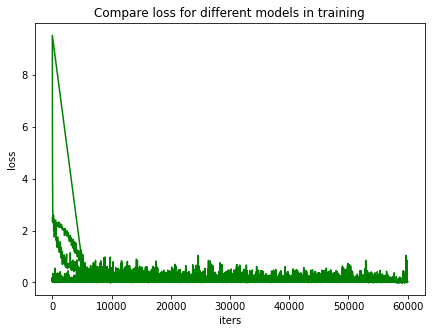

In [64]:
show(x, train_loss_list)

In [65]:
eval()

TEST-ACC:  97.89 %


#### 作业

1.对比卷积神经网络与全连接神经网络，在图像的分类任务中，原始图像大小的变化将会怎样影响模型可训练参数的个数？
* 如果是同一类的图像分类任务，只改变原始图像大小的情况下，首先这两种网络在输出层都是一样的，输出的神经元个数是一样的，差别在神经网络的输入层，全连接神经网络的输入层是图像的像素的大小，第一层神经元的参数参与了全像素点的运算，后面的神经元的参数是根据前面神经元的个数定的，而卷积神经网络是根据卷积层的定义，来决定全连接层的神经元输入层参数的个数的。因为卷积层有降采样所以前层参数只会在深度上增加，并不会增加后一层神经元的参数个数。

2.卷积神经网络是通过什么方式来完成可训练参数减少的？
* 局部连接来减少可训练参数的

3.LeNet-5每一层参数个数
* 32*32经过一个6*5*5的卷积核加6个偏置系数的输出是6 * 28 * 28
* 经过一个maxpooling输出是6 * 14 * 14
* 从s2到c3的卷积和大小不一样， 前5个的卷积核大小是3 * 5 * 5 后面9个的卷积核大小是4 * 5 * 5，最后一个是6 * 5 * 5 再加16个偏执系数
* 从c3到s4 是一个maxpooling层输出是 16 * 5 * 5
* 从s4到c5 W的shape 400 * 120 b的shape是 120 * 1
* 从c5到f6 w的shape 120 * 84 b的shape是 84 * 1
* 从f6到输出层shape 84 * 10 b的shape是 10 * 1